IMPORTS

In [4]:
import torch
from PIL import Image
import os
import shutil
import cv2
import numpy as np



Prepping Data to train on yolov5

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/ashmitha/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-28 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [17]:
all_image_names = sorted(os.listdir("ts"))

In [32]:
train_test_split = 0.8
data_len = len(all_image_names)
train_len = int(data_len * train_test_split)
test_len = int(data_len * (1 - train_test_split))


In [33]:
print(data_len, train_len)

1482 1185


In [37]:
dir_name = 'train'
    
for j, image_name in enumerate(all_image_names):
    if j == train_len -1:
        dir_name = 'test'
    if (j % 2) == 0:
        file_name = image_name.split('.jpg')[0]
        shutil.move(f"./ts/{image_name}", f"{dir_name}/images/{image_name}")
        shutil.move(f"./ts/{file_name}.txt", f"{dir_name}/labels/{file_name}.txt")

In [47]:
EPOCHS = 20

In [49]:
!python ./yolov5/train.py --data ./data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16

train: weights=yolov5s.pt, cfg=, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0

Loading trained model weights

In [15]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./detect_weights.pt')

Using cache found in /home/ashmitha/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


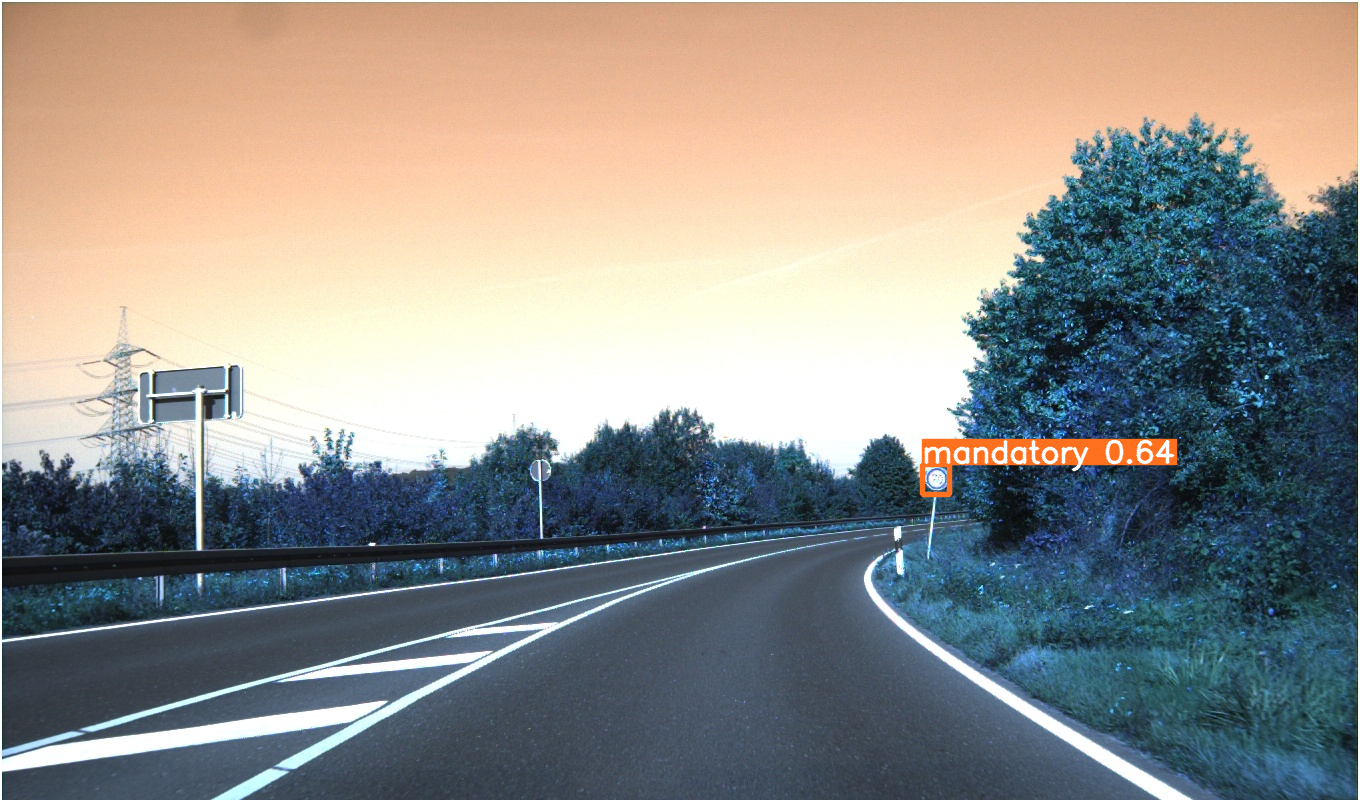

In [20]:
imgs = cv2.imread("./train_detection/images/00009.jpg")
cv2.imshow("display", imgs)
results = model(imgs)
results.show()

Processing Image for Traffic Sign Detection

In [23]:
from PIL import Image

In [25]:
img = Image.open("./train_detection/images/00009.jpg")

In [26]:
bounding_boxes = results.xyxy[0].cpu().numpy() 
for box in bounding_boxes:
    x_min, y_min, x_max, y_max, confidence, class_id = box


In [31]:
cropped_img = img.crop((x_min, y_min, x_max, y_max))
cropped_img.show()
img_np = np.array(cropped_img)

In [31]:
#Method 1
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
deconvolved_image = cv2.filter2D(img_np, -1, kernel)
cv2.imshow('Image from PIL', deconvolved_image)
cv2.imwrite('deconvolved_image.png', deconvolved_image)


True

In [32]:
low_pass = cv2.GaussianBlur(img_np, (0, 0), 5)
high_pass = img_np - low_pass
sharpened_image = img_np + 2 * high_pass
cv2.imshow('Image from PIL', sharpened_image)

In [8]:
from ESRGAN.test import esrgan

In [29]:
zesrgan_img = esrgan(img_np)
cv2.imwrite('esrgan_image.png', esrgan_img)

Model path ./ESRGAN/models/RRDB_PSNR_x4.pth. 
Testing...


True

In [26]:
cv2.imshow("esrgan image",esrgan_img)

In [33]:
cv2.waitKey(5)
cv2.destroyAllWindows()

Process Traffic Sign Recognition Data

In [44]:
import csv

In [45]:
dir_list = sorted(os.listdir("./GTSRB/Training"))

In [57]:
req_dir_list = ['00000','00001','00002', '00003', '00004', '00005', '00007','00008','00013','00014', '00024','00025', '00032']

In [59]:
req_dir_list[8]

'00013'

In [46]:
for dir in dir_list:
    path = "./GTSRB/Training/" + dir
    file_list = sorted(os.listdir(path))
    for i, name in enumerate(file_list):
        if name[-3:] == "ppm":
            image_path = path + "/" + name
            ppm_image = Image.open(image_path)
            file_name = dir + "_" + f"{i:05d}"
            ppm_image.save(path + "/" + file_name + '.jpg', 'JPEG')

            os.remove(image_path)

    file_list = sorted(os.listdir(path))

In [52]:
folder_path = "./GTSRB/Training/"

for id, item in enumerate(req_dir_list):
    csv_path = os.path.join(folder_path,item, "GT-" + item + ".csv")
    data_writer_dir = os.path.join(folder_path, item)
    
    with open(csv_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)

            next(csv_reader)
            for i, row in enumerate(csv_reader):
                x = [item.split(";") for item in row]

                file_name = item + "_" + f"{i:05d}"

                data_path = os.path.join(data_writer_dir, file_name + ".txt")

                # Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId

                width = float(x[0][1])
                height = float(x[0][2])

                # <class> <x_center> <y_center> <width> <height>
                
                x_center = int((float(x[0][3]) + float(x[0][5])))/(2 * width)
                y_center = int((float(x[0][4]) + float(x[0][6])))/(2 * height)

                box_width = abs(float(x[0][3]) - float(x[0][5]))/width
                box_height = abs(float(x[0][4]) - float(x[0][6]))/height

                x_center = str(x_center)
                y_center = str(y_center)
                box_width = str(box_width)
                box_height = str(box_height)

                class_id = str(id)

                data = class_id + " " + x_center + " " + y_center + " " + box_width + " " + box_height
                

                with open(data_path, 'w') as file:
                    file.write(data)

In [95]:
folder_path = "./GTSRB/Training/"

for item in os.listdir(folder_path):
    csv_path = os.path.join(folder_path,item, "GT-" + item + ".csv")
    data_writer_dir = os.path.join(folder_path, item)
    with open(csv_path, "r") as csv_file:
        csv_reader = csv.reader(csv_file)

        next(csv_reader)
        for i, row in enumerate(csv_reader):
            x = [item.split(";") for item in row]

            file_name = item + "_" + f"{i:05d}"

            data_path = os.path.join(data_writer_dir, file_name + ".txt")

            # Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId

            width = float(x[0][1])
            height = float(x[0][2])

            # <class> <x_center> <y_center> <width> <height>
            
            x_center = int((float(x[0][3]) + float(x[0][5])))/(2 * width)
            y_center = int((float(x[0][4]) + float(x[0][6])))/(2 * height)

            box_width = abs(float(x[0][3]) - float(x[0][5]))/width
            box_height = abs(float(x[0][4]) - float(x[0][6]))/height

            x_center = str(x_center)
            y_center = str(y_center)
            box_width = str(box_width)
            box_height = str(box_height)

            data = x[0][-1] + " " + x_center + " " + y_center + " " + box_width + " " + box_height
            

            with open(data_path, 'w') as file:
                file.write(data)
            


In [53]:
!mkdir SMALL_GTSRB
!mkdir SMALL_GTSRB/Training
!mkdir SMALL_GTSRB/Testing

In [54]:
directory_path_train = "./SMALL_GTSRB/Training"
directory_path_test = "./SMALL_GTSRB/Testing"

In [55]:
!mkdir SMALL_GTSRB/Testing/images
!mkdir SMALL_GTSRB/Testing/labels



In [56]:
!mkdir SMALL_GTSRB/Training/images
!mkdir SMALL_GTSRB/Training/labels


In [58]:
for dir in req_dir_list:
    file_list = sorted(os.listdir("./GTSRB/Training/" + dir))
    train_length = int((len(file_list)-1)*0.8)
    
    for i, file_name in enumerate(file_list):
        if file_name[-1] == "v":
            continue
        
        if i <= train_length:
            if file_name[-3:] == "jpg":
                shutil.move(f"./GTSRB/Training/{dir}/{file_name}", f"{directory_path_train}/images/{file_name}")
                shutil.move(f"./GTSRB/Training/{dir}/{file_name[:-4]}.txt", f"{directory_path_train}/labels/{file_name[:-4]}.txt")
        else:
            if file_name[-3:] == "jpg":
                shutil.move(f"./GTSRB/Training/{dir}/{file_name}", f"{directory_path_test}/images/{file_name}")
                shutil.move(f"./GTSRB/Training/{dir}/{file_name[:-4]}.txt", f"{directory_path_test}/labels/{file_name[:-4]}.txt")

    
    

Train Recog Model

In [16]:
import yaml

In [17]:
num_classes = 43


In [15]:
classes = ['20 km/h','30 km/h','50 km/h', '60 km/h', '70 km/h', '80 km/h', '100 km/h','120 km/h','Yield', 'Stop', 'Narrow Road','Men at Work', 'No Entry']

In [43]:
classes[12]

'Right-of-way at the next intersection'

In [39]:
len(classes)

43

In [ ]:
# for dir in dir_list:
#     train_path = '../GTSRB/Training/' + dir + "/images"
#     test_path = '../GTSRB/Testing/' + dir + "/images"
#     classes = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing' ,'No passing for vechiles over 3.5 metric tons', 'No vehicles' ,'Vechiles over 3.5 metric tons prohibited', 'Right-of-way at the next intersection', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right' ,'Double curve', 'Bumpy road', 'Slippery road' ,'Road narrows on the right', 'Road work' ,'Traffic signals' ,'Pedestrians', 'Children crossing', 'Bicycles crossing' ,'Beware of ice/snow' ,'Wild animals crossing' ,'Turn right ahead' ,'Turn left ahead' ,'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'Priority road', 'Yield', 'Stop', 'No entry', 'End of speed limit (80km/h)', 'End of all speed and passing limits', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons']
    
#     data = {
#         'train': train_path,
#         'val': test_path,
#         'nc': 43,
#         'names': classes
#     }

#     yaml_file_path = 'data_recog.yaml'

#     with open(yaml_file_path, 'w') as yaml_file:
#         yaml.dump(data, yaml_file, default_flow_style=False)
#     !python ./yolov5/train.py --data ./data_recog.yaml --weights yolov5s.pt \
#     --img 640 --epochs {EPOCHS} --batch-size 16
#     break

In [6]:
from ultralytics import YOLO

In [7]:
recog_model = YOLO('yolov8n.yaml')  # build a new model from YAML
recog_model = YOLO('./recog_weights1.pt')  # load a pretrained model (recommended for training)

# Train the model


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [159]:
recog_model = torch.hub.load('./yolov5/', 'custom', path='./best (2).pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


In [176]:
img = Image.open("./esrgan_image.png")


In [31]:
detected_objects = recog_model(imgs)
bounding_boxes = detected_objects.xyxy[0].cpu().numpy()
for box in bounding_boxes:
    x_min, y_min, x_max, y_max, confidence, class_id = box 


In [36]:
if len(bounding_boxes) == 0:
    print("re")


re


In [33]:
detected_objects.show

<bound method Detections.show of YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 800x1360 (no detections)
Speed: 3.0ms pre-process, 67.6ms inference, 0.4ms NMS per image at shape (1, 3, 384, 640)>

Pipiline (Detect + Recog)

In [8]:
class Pipeline:
    def __init__(self, detect, recog, image, classes):
        self.detect_model = detect
        self.recog_model = recog
        self.input = image
        self.classes = classes


    def crop_image(self):
        
        results = self.detect_model(self.input)
        
        bounding_boxes = results.xyxy[0].cpu().numpy()

        cropped_images = []
        for box in bounding_boxes:
            x_min, y_min, x_max, y_max, confidence, class_id = box
            
            if confidence > 0.3:
                cropped_img = self.input[int(y_min):int(y_max), int(x_min):int(x_max)]
                cropped_images.append([cropped_img, box])



        return cropped_images
    
    def recog_image(self):

        detects = self.crop_image()
        final_boxes = []
        final_predict = []
        for image, box in detects:
            predict = self.recog_model.predict(image, conf=0.5)
            # predict = self.recog_model(image)
            if len(predict) != 0:
                final_boxes.append(box)
                final_predict.append(predict)

        return final_boxes, final_predict
    
    def output(self):
        boxes, results = self.recog_image()

        for box, predict in zip(boxes, results):
            x_min, y_min, x_max, y_max, _, _ = box 

            # bounding_boxes = predict.xyxy[0].cpu().numpy()
            confidence = predict[0].boxes.conf
            class_id = predict[0].boxes.cls
            
            for conf, id in zip(confidence, class_id):
                
                
                if conf.numel() == 0:
                    continue

                if conf.item() > 0.7:
                    cv2.rectangle(self.input, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
                    org = (int(x_min), int(y_min) - 10)  # Adjust the coordinates to place the text above the rectangle
                    cv2.putText(self.input, self.classes[int(id)] + str(conf), org, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                   
                    # cv2.putText(self.input, str(confidence), org, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        
        cv2.imshow("output", self.input)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

            
                


        


In [9]:
imgs = cv2.imread("./train_detection/images/00009.jpg")

cv2.imshow('Image', imgs)

# Keep the window open until a key is pressed
cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()


In [177]:
img_numpy =  np.array(imgs)


In [183]:
type(imgs)

numpy.ndarray

In [187]:
cv2.imshow("output", imgs)


In [206]:
pipeline = Pipeline(model, recog_model, imgs, classes)

In [207]:
pipeline.output()

Model Output Viewing

In [24]:
cv2.destroyAllWindows()

In [1]:
import torch

In [4]:
detect_model = torch.hub.load('../yolov5/', 'custom', path='../weights/detect_weights.pt', force_reload=True, source='local')


YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [28]:
import cv2

video_capture = cv2.VideoCapture('/home/ashmitha/traffic_sign_detection/output_video.mp4')

In [2]:
from PIL import Image

In [33]:
# for img_path in os.listdir("./train_detection/images/"):
  
img = cv2.imread("./test4.jpg")
pipeline = Pipeline(detect_model, recog_model, img, classes)
pipeline.output()
cv2.moveWindow('output', 50, 50)
cv2.waitKey(0)  # Wait for a key press
cv2.destroyAllWindows() 



0: 640x640 1 Speed limit (50km/h), 65.3ms
Speed: 1.5ms preprocess, 65.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed limit (50km/h), 69.0ms
Speed: 2.2ms preprocess, 69.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [29]:
while True:
    # Read the next frame
    ret, frame = video_capture.read()
    
    pipeline = Pipeline(detect_model, recog_model, frame, classes)
    pipeline.output()
    # results = detect_model(frame)
    # bounding_boxes = results.xyxy[0].cpu().numpy()

    
    # for box in bounding_boxes:
    #     x_min, y_min, x_max, y_max, confidence, class_id = box

    #     if confidence > 0.4:
    #         cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # cv2.imshow("output", frame)
    # # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    if cv2.waitKey(0) & 0xFF == ord('n'):
        continue

# Release the video capture object and close the display window
video_capture.release()
cv2.destroyAllWindows()



0: 640x544 1 Yield, 55.5ms
Speed: 1.2ms preprocess, 55.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 43.8ms
Speed: 1.0ms preprocess, 43.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 41.6ms
Speed: 1.1ms preprocess, 41.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 52.6ms
Speed: 1.3ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 54.9ms
Speed: 1.3ms preprocess, 54.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 41.5ms
Speed: 1.2ms preprocess, 41.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 40.7ms
Speed: 1.6ms preprocess, 40.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Yield, 40.6ms
Speed: 1.3ms preprocess, 40.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


In [ ]:
import matplotlib.pyplot as plt

# Provided data
data = [
    (89868.0, 'x', 0.0),
    (90068.0, 'danger', 0.5336408019065857),
    (90334.0, 'danger', 0.4102630615234375),
    (90401.0, 'danger', 0.6532791256904602),
    (90534.0, 'danger', 0.6298872828483582),
    (90601.0, 'danger', 0.9051151871681213),
    (90668.0, 'danger', 0.8504530191421509),
    (90734.00000000001, 'danger', 0.7373319864273071),
    (90801.0, 'danger', 0.6997877955436707),
    (90868.0, 'danger', 0.797885000705719),
    (90934.0, 'danger', 0.7636812925338745),
    (91001.0, 'danger', 0.7523297071456909),
    (91068.0, 'danger', 0.41050922870635986),
    (91201.00000000001, 'mandatory', 0.5479320883750916),
    (91201.00000000001, 'danger', 0.5013111233711243),
    (91268.0, 'danger', 0.5127255916595459),
    (91334.0, 'danger', 0.6751094460487366),
    (91401.0, 'danger', 0.6924133896827698),
    (91468.0, 'danger', 0.6436444520950317),
    (91534.0, 'danger', 0.6522762179374695),
    (91601.0, 'danger', 0.797960638999939),
    (91668.0, 'danger', 0.7662821412086487),
    (91734.00000000001, 'danger', 0.5847753882408142),
    (91801.0, 'danger', 0.770136296749115),
    (91868.0, 'danger', 0.7434161305427551),
    (91934.0, 'danger', 0.6715823411941528),
    (92134.0, 'danger', 0.7763949632644653),
    (92268.0, 'danger', 0.40438833832740784),
    (92401.0, 'danger', 0.43816497921943665),
    (92468.0, 'danger', 0.7853319644927979),
    (92534.0, 'danger', 0.599166214466095),
    (92601.0, 'danger', 0.5761454701423645),
    (92668.0, 'danger', 0.720942497253418),
    (92734.00000000001, 'danger', 0.4711102247238159),
    (94068.0, 'prohibitory', 0.5728908777236938),
    (94134.0, 'prohibitory', 0.5816695094108582),
    (94201.00000000001, 'prohibitory', 0.7123885750770569),
    (94268.0, 'prohibitory', 0.6930968761444092),
    (94334.0, 'prohibitory', 0.7096788883209229),
    (94401.0, 'prohibitory', 0.804964542388916),
    (94534.0, 'other', 0.5636658072471619),
    (94601.0, 'prohibitory', 0.8112063407897949),
    (94668.0, 'prohibitory', 0.7745103240013123),
    (94734.00000000001, 'prohibitory', 0.592950165271759),
    (94801.0, 'prohibitory', 0.4456632137298584),
    (94868.0, 'prohibitory', 0.6154650449752808),
    (95334.0, 'mandatory', 0.567843496799469),
    (79201.00000000001, 'x', 0.0),
    (79668.0, 'prohibitory', 0.7854848504066467),
    (79734.0, 'prohibitory', 0.850255012512207),
    (79801.0, 'prohibitory', 0.5383897423744202),
    (79868.0, 'prohibitory', 0.8178889751434326),
    (79934.0, 'mandatory', 0.5196684002876282),
    (80001.0, 'other', 0.5525050759315491),
    (80068.0, 'prohibitory', 0.6605046987533569),
    (80134.0, 'other', 0.6737049221992493),
    (80201.00000000001, 'other', 0.6964898109436035),
    (80268.0, 'other', 0.5333887338638306),
    (80334.0, 'prohibitory', 0.6134931445121765),
    (80334.0, 'other', 0.5451489090919495),
    (80401.0, 'prohibitory', 0.5296944975852966),
    (80401.0, 'other', 0.4035239517688751),
    (80468.0, 'prohibitory', 0.7854486107826233),
    (80534.0, 'prohibitory', 0.7234305143356323),
    (80601.0, 'prohibitory', 0.8743723630905151),
    (80668.0, 'prohibitory', 0.7612780928611755),
    (80734.0, 'prohibitory', 0.796267032623291),
    (80801.0, 'prohibitory', 0.8525716066360474),
    (80868.0, 'prohibitory', 0.8858243227005005),
    (80934.0, 'prohibitory', 0.8996258974075317),
    (81001.0, 'prohibitory', 0.9193354249000549),
    (81068.0, 'prohibitory', 0.9268699884414673),
    (81068.0, 'mandatory', 0.45426544547080994),
    (81134.0, 'prohibitory', 0.9387413263320923),
    (81201.00000000001, 'prohibitory', 0.8988784551620483),
    (81201.00000000001, 'mandatory', 0.6766180396080017),
    (81268.0, 'prohibitory', 0.9349764585494995),
    (81268.0, 'mandatory', 0.42431557178497314),
    (81334.0, 'prohibitory', 0.9353354573249817),
    (81334.0, 'mandatory', 0.7455171346664429),
    (81401.0, 'prohibitory', 0.9283380508422852),
    (81401.0, 'mandatory', 0.4179329574108124),
    (81468.0, 'prohibitory', 0.9339811205863953),
    (81534.0, 'mandatory', 0.4216829836368561)
]

# Extract 'x', 'danger', 'mandatory', 'prohibitory', and 'other' values
x_values = [item[0] for item in data if item[1] == 'x']
danger_values = [item[2] for item in data if item[1] == 'danger']
mandatory_values = [item[2] for item in data if item[1] == 'mandatory']
prohibitory_values = [item[2] for item in data if item[1] == 'prohibitory']
other_values = [item[2] for item in data if item[1] == 'other']

# Plot the arrays against each other
plt.figure(figsize=(12, 8))
plt.plot(x_values, danger_values, marker='o', linestyle='-', color='red', label='danger')
plt.plot(x_values, mandatory_values, marker='o', linestyle='-', color='blue', label='mandatory')
plt.plot(x_values, prohibitory_values, marker='o', linestyle='-', color='green', label='prohibitory')
plt.plot(x_values, other_values, marker='o', linestyle='-', color='orange', label='other')
plt.xlabel('Timestamp')
plt.ylabel('Confidence Values')
plt.title('Plot of Confidence Values against Timestamp for "x" values')
plt.legend()
plt.grid(True)
plt.show()


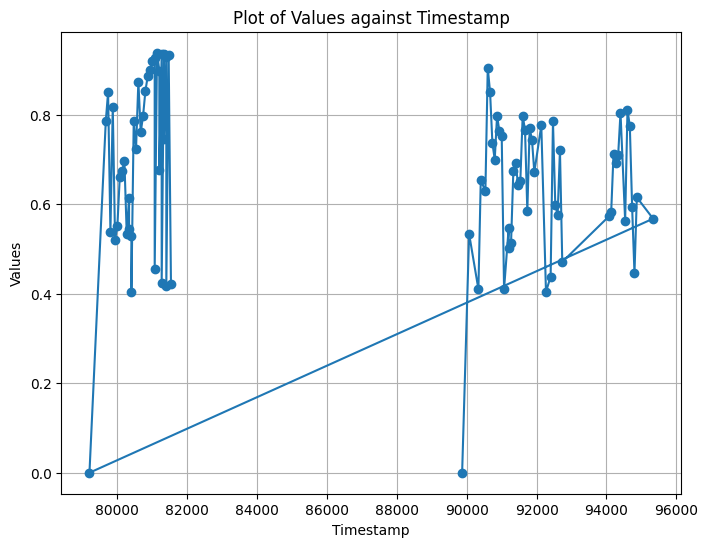

In [4]:
import matplotlib.pyplot as plt

# Provided data
data = [
    (89868.0, 'x', 0.0),
    (90068.0, 'danger', 0.5336408019065857),
    (90334.0, 'danger', 0.4102630615234375),
    (90401.0, 'danger', 0.6532791256904602),
    (90534.0, 'danger', 0.6298872828483582),
    (90601.0, 'danger', 0.9051151871681213),
    (90668.0, 'danger', 0.8504530191421509),
    (90734.00000000001, 'danger', 0.7373319864273071),
    (90801.0, 'danger', 0.6997877955436707),
    (90868.0, 'danger', 0.797885000705719),
    (90934.0, 'danger', 0.7636812925338745),
    (91001.0, 'danger', 0.7523297071456909),
    (91068.0, 'danger', 0.41050922870635986),
    (91201.00000000001, 'mandatory', 0.5479320883750916),
    (91201.00000000001, 'danger', 0.5013111233711243),
    (91268.0, 'danger', 0.5127255916595459),
    (91334.0, 'danger', 0.6751094460487366),
    (91401.0, 'danger', 0.6924133896827698),
    (91468.0, 'danger', 0.6436444520950317),
    (91534.0, 'danger', 0.6522762179374695),
    (91601.0, 'danger', 0.797960638999939),
    (91668.0, 'danger', 0.7662821412086487),
    (91734.00000000001, 'danger', 0.5847753882408142),
    (91801.0, 'danger', 0.770136296749115),
    (91868.0, 'danger', 0.7434161305427551),
    (91934.0, 'danger', 0.6715823411941528),
    (92134.0, 'danger', 0.7763949632644653),
    (92268.0, 'danger', 0.40438833832740784),
    (92401.0, 'danger', 0.43816497921943665),
    (92468.0, 'danger', 0.7853319644927979),
    (92534.0, 'danger', 0.599166214466095),
    (92601.0, 'danger', 0.5761454701423645),
    (92668.0, 'danger', 0.720942497253418),
    (92734.00000000001, 'danger', 0.4711102247238159),
    (94068.0, 'prohibitory', 0.5728908777236938),
    (94134.0, 'prohibitory', 0.5816695094108582),
    (94201.00000000001, 'prohibitory', 0.7123885750770569),
    (94268.0, 'prohibitory', 0.6930968761444092),
    (94334.0, 'prohibitory', 0.7096788883209229),
    (94401.0, 'prohibitory', 0.804964542388916),
    (94534.0, 'other', 0.5636658072471619),
    (94601.0, 'prohibitory', 0.8112063407897949),
    (94668.0, 'prohibitory', 0.7745103240013123),
    (94734.00000000001, 'prohibitory', 0.592950165271759),
    (94801.0, 'prohibitory', 0.4456632137298584),
    (94868.0, 'prohibitory', 0.6154650449752808),
    (95334.0, 'mandatory', 0.567843496799469),
    (79201.00000000001, 'x', 0.0),
    (79668.0, 'prohibitory', 0.7854848504066467),
    (79734.0, 'prohibitory', 0.850255012512207),
    (79801.0, 'prohibitory', 0.5383897423744202),
    (79868.0, 'prohibitory', 0.8178889751434326),
    (79934.0, 'mandatory', 0.5196684002876282),
    (80001.0, 'other', 0.5525050759315491),
    (80068.0, 'prohibitory', 0.6605046987533569),
    (80134.0, 'other', 0.6737049221992493),
    (80201.00000000001, 'other', 0.6964898109436035),
    (80268.0, 'other', 0.5333887338638306),
    (80334.0, 'prohibitory', 0.6134931445121765),
    (80334.0, 'other', 0.5451489090919495),
    (80401.0, 'prohibitory', 0.5296944975852966),
    (80401.0, 'other', 0.4035239517688751),
    (80468.0, 'prohibitory', 0.7854486107826233),
    (80534.0, 'prohibitory', 0.7234305143356323),
    (80601.0, 'prohibitory', 0.8743723630905151),
    (80668.0, 'prohibitory', 0.7612780928611755),
    (80734.0, 'prohibitory', 0.796267032623291),
    (80801.0, 'prohibitory', 0.8525716066360474),
    (80868.0, 'prohibitory', 0.8858243227005005),
    (80934.0, 'prohibitory', 0.8996258974075317),
    (81001.0, 'prohibitory', 0.9193354249000549),
    (81068.0, 'prohibitory', 0.9268699884414673),
    (81068.0, 'mandatory', 0.45426544547080994),
    (81134.0, 'prohibitory', 0.9387413263320923),
    (81201.00000000001, 'prohibitory', 0.8988784551620483),
    (81201.00000000001, 'mandatory', 0.6766180396080017),
    (81268.0, 'prohibitory', 0.9349764585494995),
    (81268.0, 'mandatory', 0.42431557178497314),
    (81334.0, 'prohibitory', 0.9353354573249817),
    (81334.0, 'mandatory', 0.7455171346664429),
    (81401.0, 'prohibitory', 0.9283380508422852),
    (81401.0, 'mandatory', 0.4179329574108124),
    (81468.0, 'prohibitory', 0.9339811205863953),
    (81534.0, 'mandatory', 0.4216829836368561)
]



# Extract x and y values
x_values = [item[0] for item in data]
y_values = [item[2] for item in data]

# Plot the arrays against each other
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Plot of Values against Timestamp')
plt.grid(True)
plt.show()
